# Alexa Sentiment Analysis
---

### Loading Packages and Dependencies
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string
import shap
import spacy
import eli5
import pickle
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
warnings.simplefilter('ignore')
sns.set(style="white", palette="muted", color_codes=True)
spacy_nlp = spacy.load('en_core_web_sm')
shap.initjs()
outputdir = 'Model_Ouput'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

### Loading dataset
---

Dataset Source: https://www.kaggle.com/sid321axn/amazon-alexa-reviews/data

In [2]:
dataset = pd.read_csv('amazon_alexa.tsv',sep='\t') # reading dataset
dataset.dropna(inplace =True) # dropping null value is there are any
dataset.sample(5) # sample of 5 rows 

,rating,date,variation,verified_reviews,feedback
2340,5,30-Jul-18,Configuration: Fire TV Stick,Easy to set up; Easy to use!,1
1638,5,29-Jul-18,White Show,My daughter has an Echo Show and she told me h...,1
2169,5,30-Jul-18,Configuration: Fire TV Stick,"Works as expected, very easy to setup and use",1
1201,5,28-Jul-18,Black Spot,Best looking Echo device. Easy to use,1
3112,5,30-Jul-18,Black Dot,This is my second Echo to purchase -- the pri...,1


In [3]:
print('Observations:',dataset.shape[0],'\n','Features:',dataset.shape[1])  # Displaying dimension of data

Observations: 3150 
 Features: 5


#### Data Visualization
----

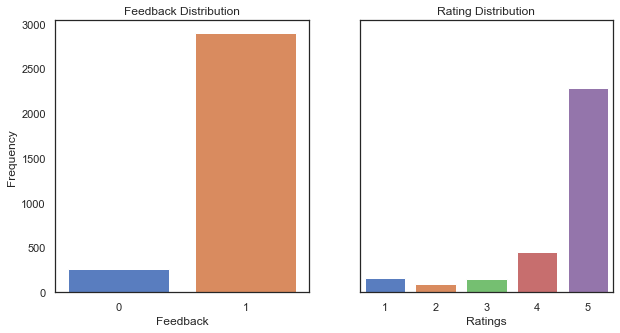

In [4]:
#Displaying distribution of the Feedback and Ratings
fig,ax = plt.subplots(1,2,sharey=True,figsize=(10,5))
plt.subplots_adjust(hspace=0.5)
ax[0].set_title('Feedback Distribution')
ax[1].set_title('Rating Distribution')
sns.countplot(dataset['feedback'],ax=ax[0])
sns.countplot(dataset['rating'],ax=ax[1])
ax[0].set_xlabel('Feedback')
ax[1].set_xlabel('Ratings')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('')
#plt.savefig('Distribution.png')
plt.show()

* Its seems that positive class is more than the negative class, which indicate imbalance of class.
* Moreover there are more people has provided rating of 5 star to Alexa product which indicate that customer is satosfied with the product.

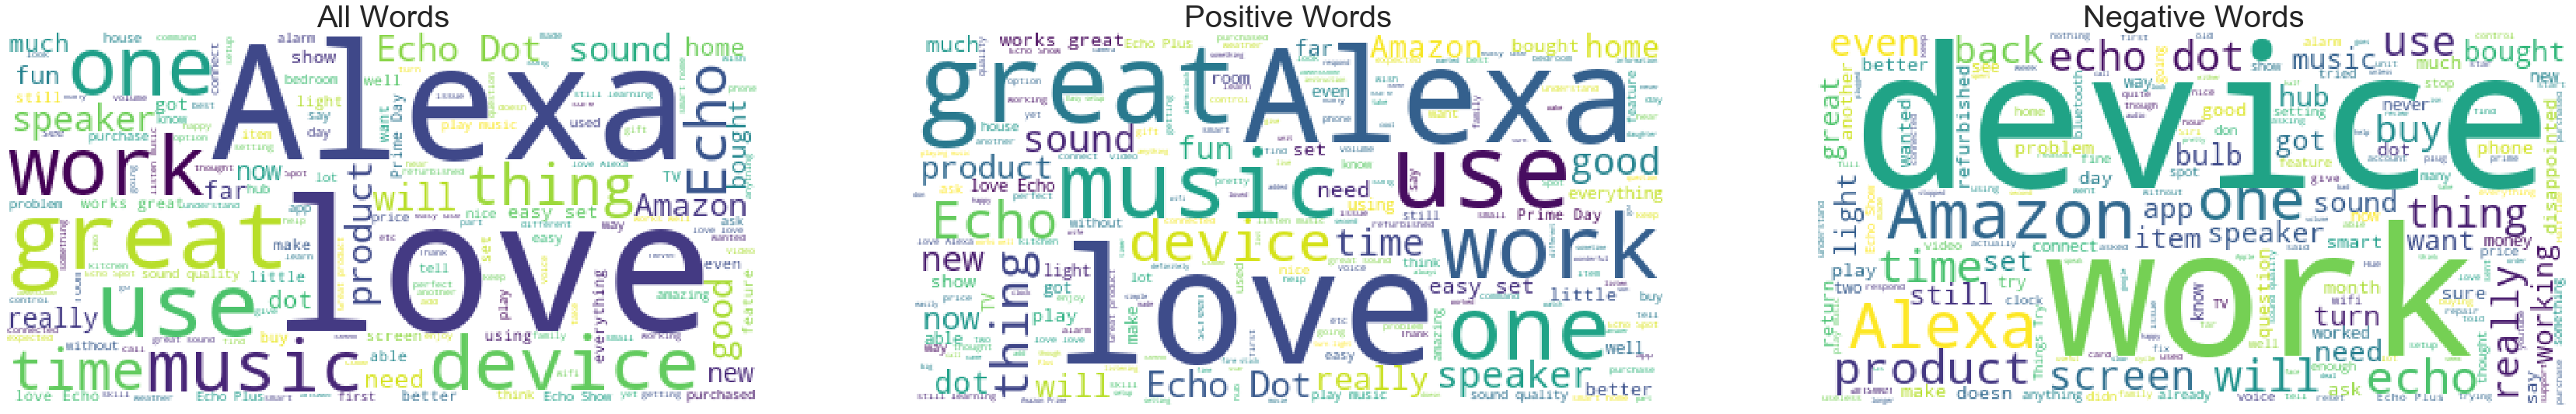

In [5]:
# Displaying word cloud
from wordcloud import WordCloud

All_word = ''.join(dataset['verified_reviews'].tolist()) # All words in the given corpus
positive_words = ''.join(dataset[dataset['feedback']==1]['verified_reviews'].tolist()) # All positive words
negative_words = ''.join(dataset[dataset['feedback']==0]['verified_reviews'].tolist()) # All negative words
category = ['All Words','Positive Words','Negative Words']
data_wordcloud = [All_word,positive_words,negative_words]

plt.figure(figsize=(80,80))
for i in range(0,3):
    t=i+1
    plt.subplot(5, 4, t).set_title(category[i],fontsize=40)
    plt.axis('off')
    plt.imshow(WordCloud(background_color='white').generate(data_wordcloud[i]))
#plt.savefig('Wordcloud.png')
plt.show()

#### Text Preprocessing
-----

In [6]:
def text_cleaning(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in list(spacy.lang.en.stop_words.STOP_WORDS)+list(string.punctuation)]
    return ' '.join(text)

In [7]:
dataset['verified_reviews_clean'] = dataset['verified_reviews'].apply(lambda x: text_cleaning(x))
reviews = dataset['verified_reviews_clean']
feedback = dataset['feedback']

#### Termite plot for TFIDF

In [8]:
# Termite will help us know, which words provide an import to category
category = list(feedback.unique())
vectorizer = TfidfVectorizer()
vectorizer.fit(dataset['verified_reviews_clean']) #Fitting TFIDF vectorizer on dataset

mat_tfidf_cat0 = vectorizer.transform(dataset[feedback==category[0]]['verified_reviews_clean']) # creating a matrix
category0_score = mat_tfidf_cat0.sum(axis=0) # taking sum of the matrix for all rows
category0_words_frequency = [(word, category0_score[0, idx]) for word, idx in vectorizer.vocabulary_.items()] # form a list all tuple with (words, score) 
df_cat0 = pd.DataFrame(list(sorted(category0_words_frequency, key = lambda x: x[1], reverse=True)),columns=['feature','Positive']) #Sort and form a dataframe
df_cat0 = df_cat0.head(10) # take top 10 row

mat_tfidf_cat1 = vectorizer.transform(dataset[feedback==category[1]]['verified_reviews_clean'])
category0_score = mat_tfidf_cat1.sum(axis=0)
category0_words_frequency = [(word, category0_score[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
df_cat1 = pd.DataFrame(list(sorted(category0_words_frequency, key = lambda x: x[1], reverse=True)),columns=['feature','Negative'])
df_cat1 = df_cat1.head(10)

df_categories = pd.merge(df_cat0,df_cat1,how='outer') #join two dataframes
df_categories.fillna(0,inplace=True) #Fill all nan with 0
df_categories.set_index('feature',inplace=True) # set all words as index
df_categories_norm = (df_categories)/(df_categories.max()-df_categories.min()) # standard normalization

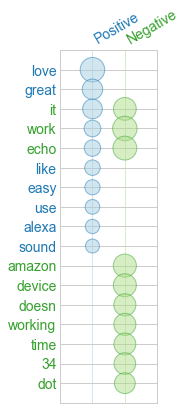

In [9]:
import numpy as np
from textacy.viz.termite import draw_termite_plot
draw_termite_plot(np.array(df_categories_norm.values),df_categories_norm.columns,df_categories_norm.index,highlight_cols=[0,1])
plt.show()

In [10]:
xtrain,xtest,ytrain,ytest = train_test_split(reviews,feedback,test_size=0.2,random_state=45) #splitting dataset with test size as 20%

In [11]:
#Creating dataset for Bag of word model
countvect = CountVectorizer()
review_train_vectorize = countvect.fit_transform(xtrain)
review_test_vectorize = countvect.transform(xtest)

#Creating dataset for TFIDF model
tfidf_transform = TfidfTransformer()
review_train_tfidf = tfidf_transform.fit_transform(review_train_vectorize)
review_test_tfidf = tfidf_transform.transform(review_test_vectorize)

### Machine Learning Model Building
----

#### Naive Bayes

In [12]:
#Bow model
nb = MultinomialNB()
nb.fit(review_train_vectorize,ytrain)
y_pred_vect = nb.predict(review_test_vectorize)
print(classification_report(ytest,y_pred_vect))
print(f'Accuracy Score:{accuracy_score(ytest,y_pred_vect)}')
print(f'AUCROC Score:{roc_auc_score(ytest,y_pred_vect)}')

with open(outputdir+'/naive_bayes_bow.pkl','wb') as file:
    pickle.dump(nb,file)

              precision    recall  f1-score   support

           0       0.73      0.22      0.33        51
           1       0.93      0.99      0.96       579

   micro avg       0.93      0.93      0.93       630
   macro avg       0.83      0.60      0.65       630
weighted avg       0.92      0.93      0.91       630

Accuracy Score:0.9301587301587302
AUCROC Score:0.6043889058213959


In [13]:
#TFIDF model
nb.fit(review_train_tfidf,ytrain)
ypred_nb_tfidf = nb.predict(review_test_tfidf)
print(classification_report(ytest,ypred_nb_tfidf))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_nb_tfidf)}')
print(f'AUCROC Score:{roc_auc_score(ytest,ypred_nb_tfidf)}')

with open(outputdir+'/naive_bayes_tfidf.pkl','wb') as file:
    pickle.dump(nb,file)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.92      1.00      0.96       579

   micro avg       0.92      0.92      0.92       630
   macro avg       0.46      0.50      0.48       630
weighted avg       0.84      0.92      0.88       630

Accuracy Score:0.919047619047619
AUCROC Score:0.5


#### SVM

In [14]:
#Bow model
svm = SVC(kernel='linear')
svm.fit(review_train_vectorize,ytrain)
ypred_vect_svm = svm.predict(review_test_vectorize)
print(classification_report(ytest,ypred_vect_svm))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_vect_svm)}')
print(f'AUC ROC Score:{roc_auc_score(ytest,ypred_vect_svm)}')

with open(outputdir+'/svm_bow.pkl','wb') as file:
    pickle.dump(nb,file)

              precision    recall  f1-score   support

           0       0.63      0.53      0.57        51
           1       0.96      0.97      0.97       579

   micro avg       0.94      0.94      0.94       630
   macro avg       0.79      0.75      0.77       630
weighted avg       0.93      0.94      0.93       630

Accuracy Score:0.9365079365079365
AUC ROC Score:0.750888956618917


In [15]:
#TFIDF model
svm.fit(review_train_tfidf,ytrain)
ypred_tfidf_svm = svm.predict(review_test_tfidf)
print(classification_report(ytest,ypred_tfidf_svm))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_tfidf_svm)}')
print(f'AUC ROC Score:{roc_auc_score(ytest,ypred_tfidf_svm)}')

with open(outputdir+'/svm_tfidf.pkl','wb') as file:
    pickle.dump(svm,file)

              precision    recall  f1-score   support

           0       0.92      0.22      0.35        51
           1       0.94      1.00      0.97       579

   micro avg       0.93      0.93      0.93       630
   macro avg       0.93      0.61      0.66       630
weighted avg       0.93      0.93      0.92       630

Accuracy Score:0.9349206349206349
AUC ROC Score:0.6069795793965255


#### Interpret Model
----

#### Feature Importance

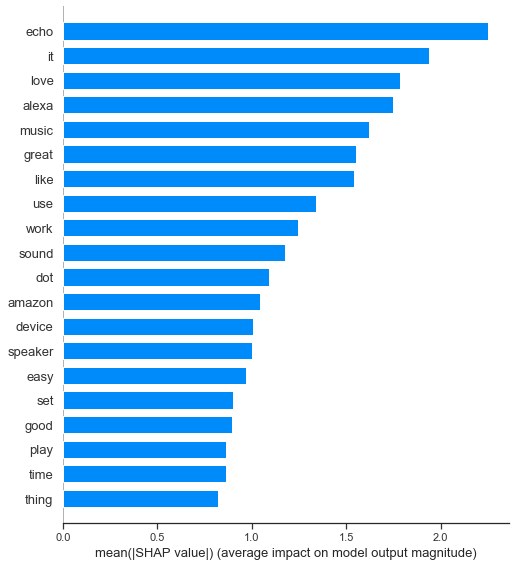

In [16]:
explainer = shap.LinearExplainer(nb,review_train_vectorize,feature_dependence='independent')
shap_values = explainer.shap_values(review_test_vectorize)
review_test_vectorize_array = review_test_vectorize.toarray()
shap.summary_plot(shap_values,review_test_vectorize_array,feature_names=countvect.get_feature_names(),plot_type='bar',layered_violin_max_num_bins=20)

#### Force Plot

In [17]:
#Verifying the results
def get_row_index(ytest,row_number):
    t_text = ytest.reset_index()
    return t_text['index'][row_number]

i=10
print('Predicted Review:', "Positive" if ytest.iloc[i] else "Negative")
print('Actual Review:',reviews[get_row_index(ytest,i)])
shap.force_plot(explainer.expected_value,shap_values[i,:],review_test_vectorize_array[i,:],feature_names=countvect.get_feature_names())

Predicted Review: Positive
Actual Review: bought son love it.


In [18]:
eli5.show_prediction(svm,xtest[get_row_index(ytest,i)],vec=countvect,target_names=ytest)

In [19]:
i=121
print('Predicted Review:', "Positive" if ytest.iloc[i] else "Negative")
print('Actual Review:',reviews[get_row_index(ytest,i)])
shap.force_plot(explainer.expected_value,shap_values[i,:],review_test_vectorize_array[i,:],feature_names=countvect.get_feature_names())

Predicted Review: Negative
Actual Review: bought echo dot refurbished stop function performing often, doesn't wake time, randomly turn nothing. buy refurbished echo dot.


In [20]:
eli5.show_prediction(svm,xtest[get_row_index(ytest,121)],vec=countvect,target_names=ytest)

### Deep Learning Model Building

In [21]:
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,AUC
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.utils import plot_model,to_categorical
from keras_tqdm import TQDMNotebookCallback,TQDMCallback
from tqdm import autonotebook

In [22]:
# You need to install nodejs and jupyterlab-manger for keras-tqdm to work in the notebook
#conda install -c conda-forge nodejs
#jupyter labextension install @jupyter-widgets/jupyterlab-manager

### Preprocessing

In [23]:
epoch = 15
batch_size = 64

n_unique_words = 10000
n_dim = 64
max_input_len = 100
drop_emb = 0.3

n_lstm = 128
drop_lstm = 0.2

# n_filter = 64
# n_kernel = 3

In [24]:
X = dataset['verified_reviews']
y = dataset['feedback']

In [25]:
xtrain, xval, ytrain, yval = train_test_split(X,y,test_size=0.2,random_state=45)

In [26]:
tokenizer = Tokenizer(n_unique_words+1)
tokenizer.fit_on_texts(xtrain)

xtrain = tokenizer.texts_to_sequences(xtrain)
xval = tokenizer.texts_to_sequences(xval)

In [27]:
xtrain_seq = sequence.pad_sequences(xtrain,maxlen=max_input_len)
xval_seq = sequence.pad_sequences(xval,maxlen=max_input_len)

In [28]:
ytrain = np.array(ytrain)  
yval = np.array(yval)

#### Bi-directional LSTM Architecture

In [29]:
model = Sequential()
model.add(Embedding(n_unique_words,n_dim,input_length=max_input_len))
model.add(SpatialDropout1D(drop_emb))
model.add(Bidirectional(LSTM(n_lstm,recurrent_dropout=drop_lstm)))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 837,889
Trainable params: 837,889
Non-trainable params: 0
_________________________________________________________________


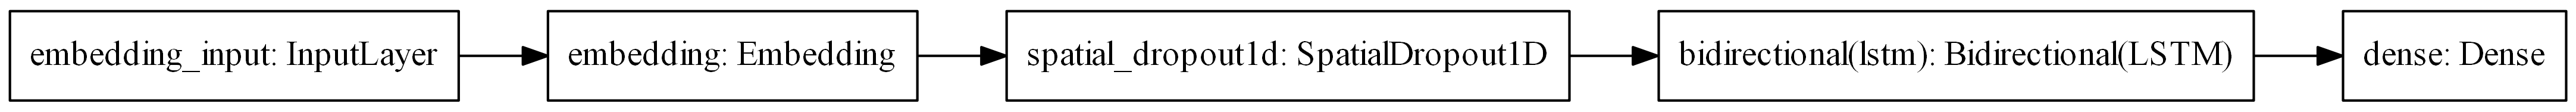

In [30]:
plot_model(model,rankdir='LR',dpi=300)

In [31]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
model_hist = model.fit(x=xtrain_seq,
                       y=ytrain,
                       validation_split=0.1,
                       batch_size=batch_size,
                       epochs=epoch,
                       verbose=0,
                       callbacks=[TQDMNotebookCallback(leave_outer=True,show_outer=True, show_inner=False)])

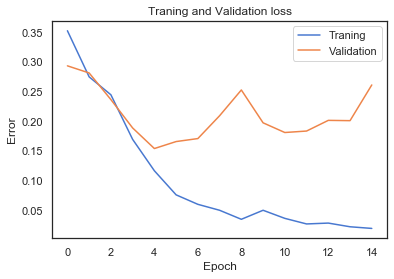

In [33]:
# Error

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('Traning and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Traning','Validation'])
plt.show()

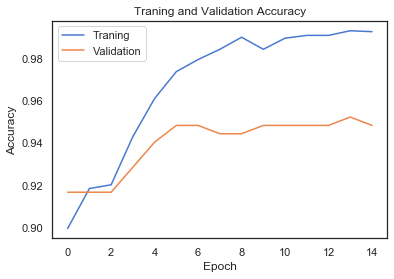

In [34]:
#Accuracy

plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Traning','Validation'])
plt.show()

In [35]:
#Model evaluation and prediction

Score= model.evaluate(xval_seq,yval,verbose=0,callbacks=[TQDMNotebookCallback(leave_outer=True,show_outer=True, show_inner=False)])
print(f'Loss:{Score[0]}')
print(f'Accuracy:{Score[1]}')
y_pred_model = model.predict(xval_seq)
print('AUC-ROC Score:',roc_auc_score(yval,y_pred_model.ravel()))
print(classification_report(yval,y_pred_model.ravel().round()))

Loss:0.262358100883781
Accuracy:0.9460317492485046
AUC-ROC Score: 0.8858410376240305
              precision    recall  f1-score   support

           0       0.84      0.41      0.55        51
           1       0.95      0.99      0.97       579

   micro avg       0.95      0.95      0.95       630
   macro avg       0.90      0.70      0.76       630
weighted avg       0.94      0.95      0.94       630



In [36]:
#Saving the model
model.save(outputdir+'/bilstm_network.h5')

#### Multi Convolutional Layer Architecture

In [37]:
input_layer = Input(shape = (max_input_len,),dtype='int16',name='input_Layer')

embedding_layer = Embedding(n_unique_words,n_dim,input_length=max_input_len,name='Embedding_layer')(input_layer)
drop_embedding_layer = SpatialDropout1D(0.3,name='Drop_Embedding_Layer')(embedding_layer)

Conv1 = Conv1D(128,3,activation='relu')(drop_embedding_layer)
maxpool1 = GlobalMaxPool1D(name='Max_Pooling_Layer_1')(Conv1)

Conv2 = Conv1D(128,2,activation='relu')(drop_embedding_layer)
maxpool2 = GlobalMaxPool1D(name='Max_Pooling_Layer_2')(Conv2)

Conv3 = Conv1D(128,4,activation='relu')(drop_embedding_layer)
maxpool3 = GlobalMaxPool1D(name='Max_Pooling_Layer_3')(Conv3)

concat = concatenate([maxpool1,maxpool2,maxpool3])
    
dense_layer = Dense(64,activation='relu',name = 'Dense_Layer')(concat)
drop_dense_layer = Dropout(0.3,name='Drop_Dense_Layer')(dense_layer)

Prediction = Dense(1,activation='sigmoid',name = 'Prediction')(drop_dense_layer)

model_custom = Model(input_layer,Prediction)

In [38]:
model_custom.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_Layer (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 100, 64)      640000      input_Layer[0][0]                
__________________________________________________________________________________________________
Drop_Embedding_Layer (SpatialDr (None, 100, 64)      0           Embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 98, 128)      24704       Drop_Embedding_Layer[0][0]       
______________________________________________________________________________________________

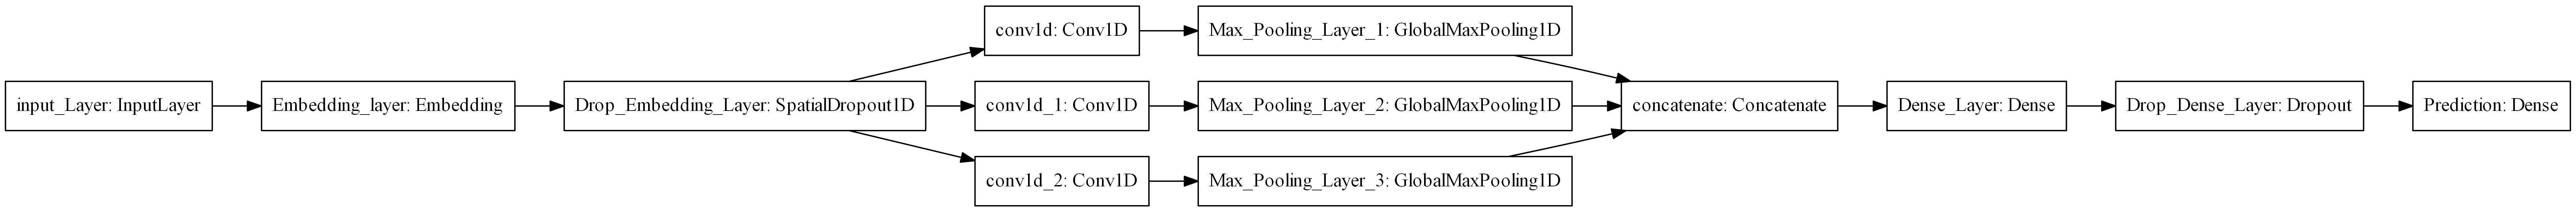

In [39]:
plot_model(model_custom,to_file='Model_Custom.png',rankdir='LR',dpi=300)

In [40]:
model_custom.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
model_custom_hist = model_custom.fit(x=xtrain_seq,
                       y=ytrain,
                       validation_split=0.1,
                       batch_size=batch_size,
                       epochs=epoch,
                       verbose=0,
                       callbacks=[TQDMNotebookCallback(leave_outer=True,show_outer=True, show_inner=False)])

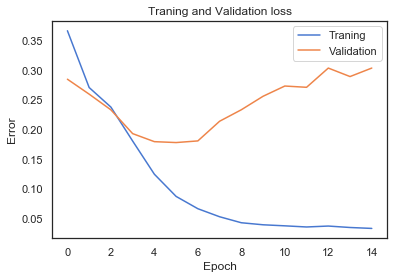

In [42]:
# Error

plt.plot(model_custom_hist.history['loss'])
plt.plot(model_custom_hist.history['val_loss'])
plt.title('Traning and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Traning','Validation'])
plt.show()

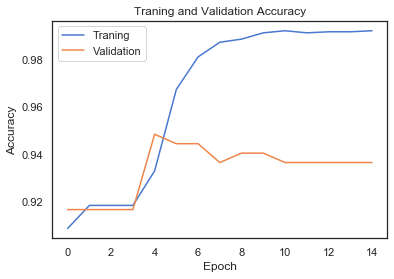

In [43]:
#Accuracy

plt.plot(model_custom_hist.history['accuracy'])
plt.plot(model_custom_hist.history['val_accuracy'])
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Traning','Validation'])
plt.show()

In [44]:
#Model Evaluation and prediction

Score= model_custom.evaluate(xval_seq,yval,verbose=0,callbacks=[TQDMNotebookCallback(leave_outer=True,show_outer=True, show_inner=False)])
print(f'Loss:{Score[0]}')
print(f'Accuracy:{Score[1]}')
y_pred_cust_model = model_custom.predict(xval_seq)
print('AUC-ROC Score:',roc_auc_score(yval,y_pred_cust_model.ravel()))
print(classification_report(yval,y_pred_cust_model.ravel().round()))

Loss:0.21806348519665855
Accuracy:0.9507936239242554
AUC-ROC Score: 0.9453926648379559
              precision    recall  f1-score   support

           0       0.83      0.49      0.62        51
           1       0.96      0.99      0.97       579

   micro avg       0.95      0.95      0.95       630
   macro avg       0.90      0.74      0.80       630
weighted avg       0.95      0.95      0.94       630



In [45]:
#Saving the model
model_custom.save(outputdir+'/customize_conv_network.h5')